# Assignment 1
## Problem 1 - System Identification

In [31]:
%reload_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np

from src.models.mls_models import PolynomialModel, RBFModel, MLPModel
from src.utils.plotting import init_plot_style
# %pylab

exportCSV = True

init_plot_style()
# Default path
# data_dir='../../data/csv/1_1_system_identification/'
# Working setup
data_dir='data/csv/1_1_system_identification/'

First, let's take a look at the training and test data.

Number of train samples is 40.
Number of test samples is 25.


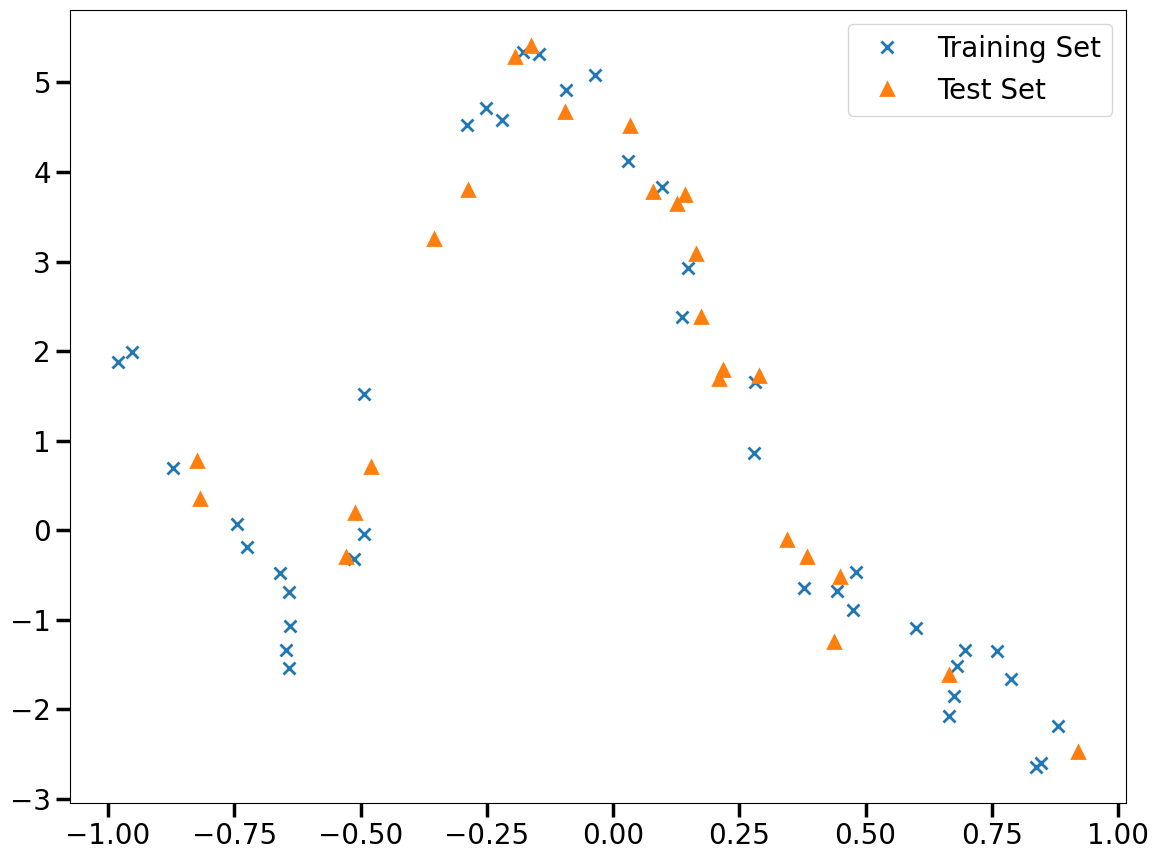

In [15]:
train_data = pd.read_csv(data_dir + 'training-set.csv').to_numpy()
x_train, y_train = train_data[:,0], train_data[:,1]
print(f'Number of train samples is {len(x_train)}.')

test_data = pd.read_csv(data_dir + 'test-set.csv').to_numpy()
x_test, y_test = test_data[:,0], test_data[:,1]
print(f'Number of test samples is {len(x_test)}.')

plt.close('all')
plt.figure()
plt.plot(x_train, y_train, 'x', label='Training Set')
plt.plot(x_test, y_test, '^', label='Test Set')
plt.legend()
plt.tight_layout()


Fit and evaluate a polynomial model of varying order.

Best train model has order 15 with train/test MSE is 0.11012250668096443 / 6.211464314620738.
Best test model has order 7 with train/test MSE is 0.16949401049480536 / 0.14195836481186438.


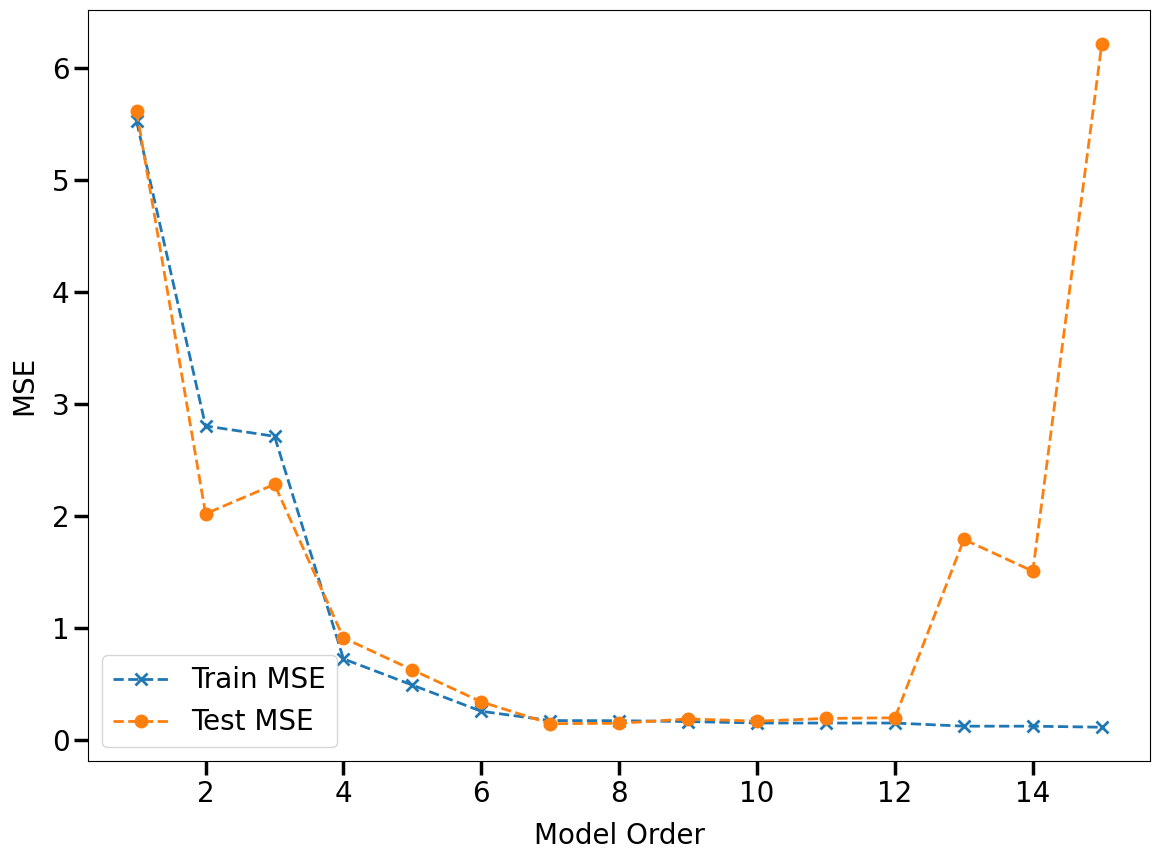

In [16]:
max_order = 15
model_class = PolynomialModel

train_mse_list = []
test_mse_list = []
for order in range(1, max_order+1):
    model = model_class(order)
    train_mse_list.append(model.fit(x_train, y_train))
    test_mse = np.mean((model.predict(x_test) - y_test)**2)
    test_mse_list.append(test_mse)

best_train_order = np.argmin(np.array(train_mse_list)) + 1
print(f'Best train model has order {best_train_order} with train/test MSE is {train_mse_list[best_train_order-1]} / {test_mse_list[best_train_order-1]}.')

best_test_order = np.argmin(np.array(test_mse_list)) + 1
print(f'Best test model has order {best_test_order} with train/test MSE is {train_mse_list[best_test_order-1]} / {test_mse_list[best_test_order-1]}.')

plt.close('all')
plt.figure()
plt.plot(list(range(1,max_order+1)), train_mse_list, 'x--', label='Train MSE')
plt.plot(list(range(1,max_order+1)), test_mse_list, 'o--', label='Test MSE')
plt.legend()
plt.xlabel('Model Order')
plt.ylabel('MSE')
plt.tight_layout()

if exportCSV:
    dataFrame = np.stack((list(range(1,max_order+1)), train_mse_list, test_mse_list), axis=1)
    np.savetxt("res/1_fitPoly.csv", dataFrame, delimiter=",", header="Model Order,Train MSE,Test MSE")

Compare the best train and test models.

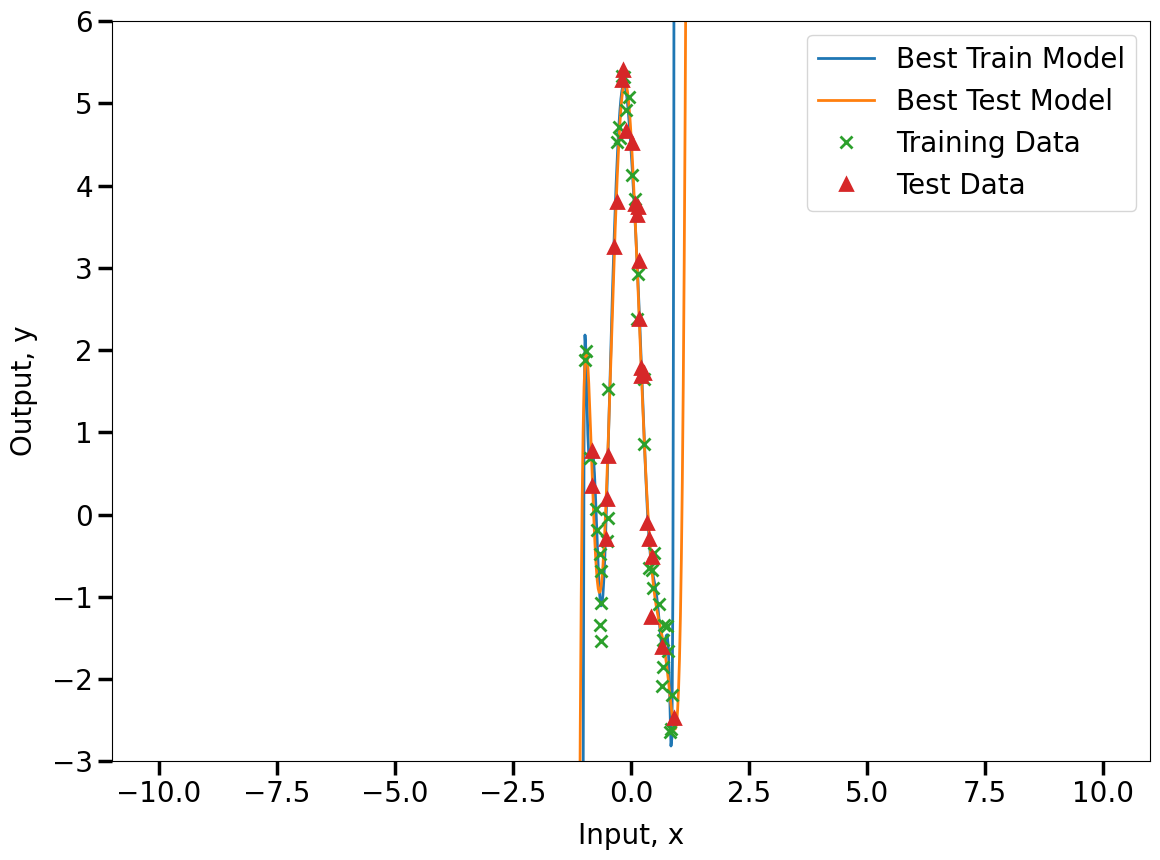

In [17]:
best_train_model = model_class(best_train_order)
_ = best_train_model.fit(x_train, y_train)

best_test_model = model_class(best_test_order)
_ = best_test_model.fit(x_train, y_train)


x_support = torch.linspace(-10., 10., 1000).numpy()
y_support_test = best_test_model.predict(x_support)
y_support_train = best_train_model.predict(x_support)

if exportCSV:
    dataFrame = np.stack((x_support, y_support_train ,y_support_test), axis=1)
    np.savetxt('res/1_resPoly.csv', dataFrame, delimiter=',', header='x,Train,Test')

plt.close('all')
plt.figure()
plt.plot(x_support, y_support_train, label='Best Train Model')
plt.plot(x_support, y_support_test, label='Best Test Model')
plt.plot(x_train, y_train, 'x', label='Training Data')
plt.plot(x_test, y_test, '^', label='Test Data')
plt.legend()
plt.xlabel('Input, x')
plt.ylabel('Output, y')
plt.ylim([-3, 6])
plt.tight_layout()

Spliting test and validation

Best train model has order 15 with train/validation MSE is 0.11012250668096443 / 0.16212276896948155.
Best test model has order 6 with train/validation/test MSE is 0.2523754837659311 / 0.13703380750847308 / 0.6356561280706295.


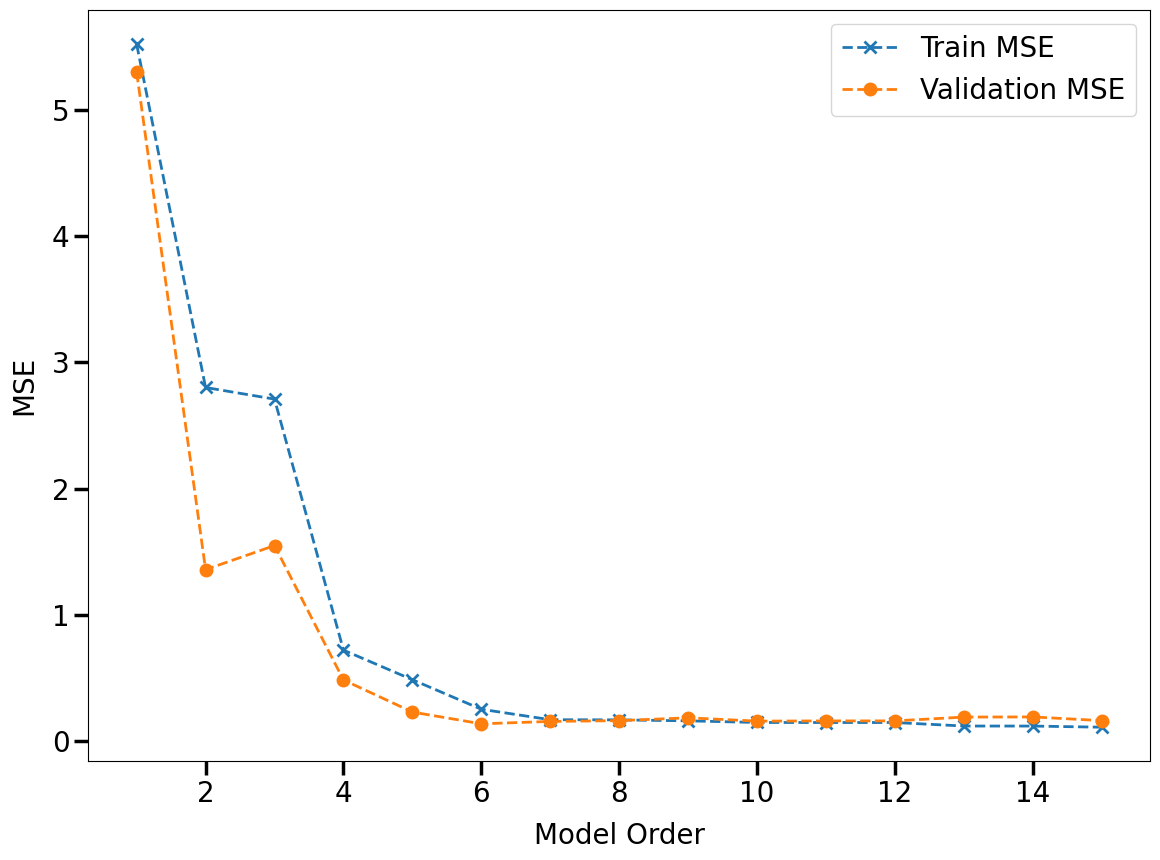

In [22]:
max_order = 15
model_class = PolynomialModel

choice = np.random.choice(range(test_data.shape[0]), size=(int(0.6 * test_data.shape[0]),1), replace=False)
ind = np.zeros(test_data.shape[0], dtype=bool)
ind[choice] = True

val_set = test_data[ind]
test_set = test_data[~ind]

train_mse_list = []
val_mse_list = []
models = []
for order in range(1, max_order+1):
    model = model_class(order)
    train_mse_list.append(model.fit(x_train, y_train))
    val_mse = np.mean((model.predict(val_set[:,0]) - val_set[:,1])**2)
    val_mse_list.append(val_mse)
    models.append(model)

best_train_order = np.argmin(np.array(train_mse_list)) + 1
print(f'Best train model has order {best_train_order} with train/validation MSE is {train_mse_list[best_train_order-1]} / {val_mse_list[best_train_order-1]}.')

best_val_order = np.argmin(np.array(val_mse_list)) + 1

test_mse = np.mean((models[best_val_order-1].predict(test_set[:,0]) - test_set[:,1])**2)

print(f'Best test model has order {best_val_order} with train/validation/test MSE is {train_mse_list[best_val_order-1]} / {val_mse_list[best_val_order-1]} / {test_mse}.')

plt.close('all')
plt.figure()
plt.plot(list(range(1,max_order+1)), train_mse_list, 'x--', label='Train MSE')
plt.plot(list(range(1,max_order+1)), val_mse_list, 'o--', label='Validation MSE')
plt.legend()
plt.xlabel('Model Order')
plt.ylabel('MSE')
plt.tight_layout()

if exportCSV:
    dataFrame = np.stack((list(range(1,max_order+1)), train_mse_list, val_mse_list), axis=1)
    np.savetxt("res/1_fitVal.csv", dataFrame, delimiter=",", header="Model Order,Train MSE,Validation MSE")

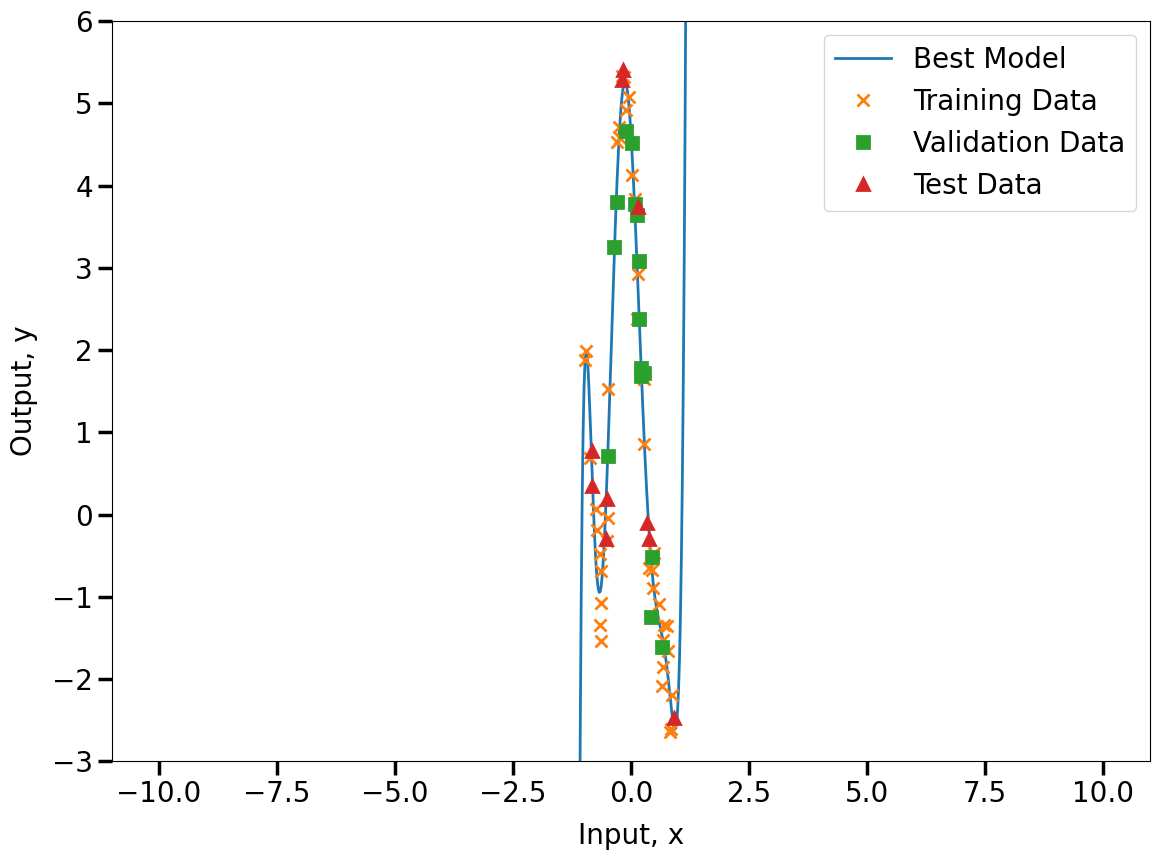

In [23]:
x_support = torch.linspace(-10., 10., 1000).numpy()
y_support = models[best_val_order].predict(x_support)

if exportCSV:
    dataFrame = np.stack((x_support, y_support), axis=1)
    np.savetxt('res/1_resVal.csv', dataFrame, delimiter=',')
    np.savetxt('res/1_dataVal.csv', val_set, delimiter=',')
    np.savetxt('res/1_dataTest.csv', test_set, delimiter=',')

plt.close('all')
plt.figure()
plt.plot(x_support, y_support, label='Best Model')
plt.plot(x_train, y_train, 'x', label='Training Data')
plt.plot(val_set[:,0], val_set[:,1], 's', label='Validation Data')
plt.plot(test_set[:,0], test_set[:,1], '^', label='Test Data')
plt.legend()
plt.xlabel('Input, x')
plt.ylabel('Output, y')
plt.ylim([-3, 6])
plt.tight_layout()

Repeat for RBF filter

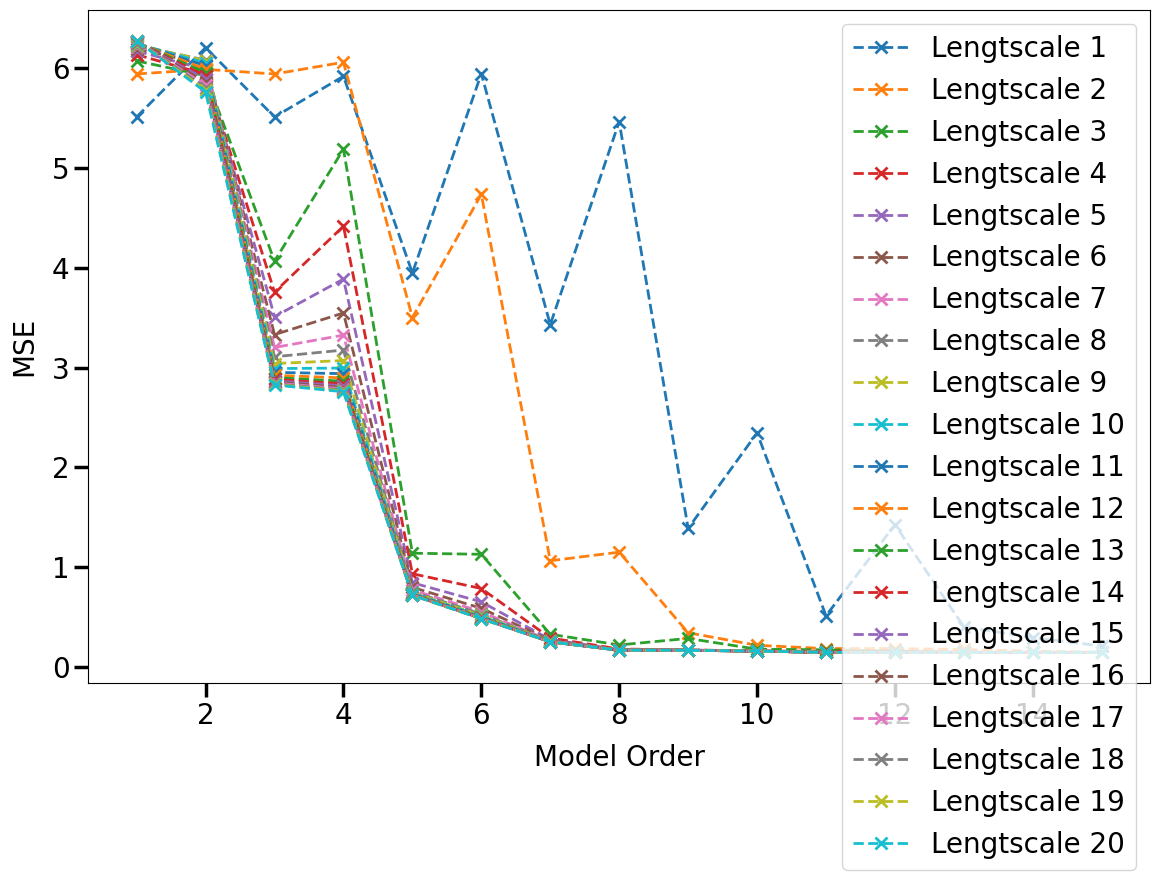

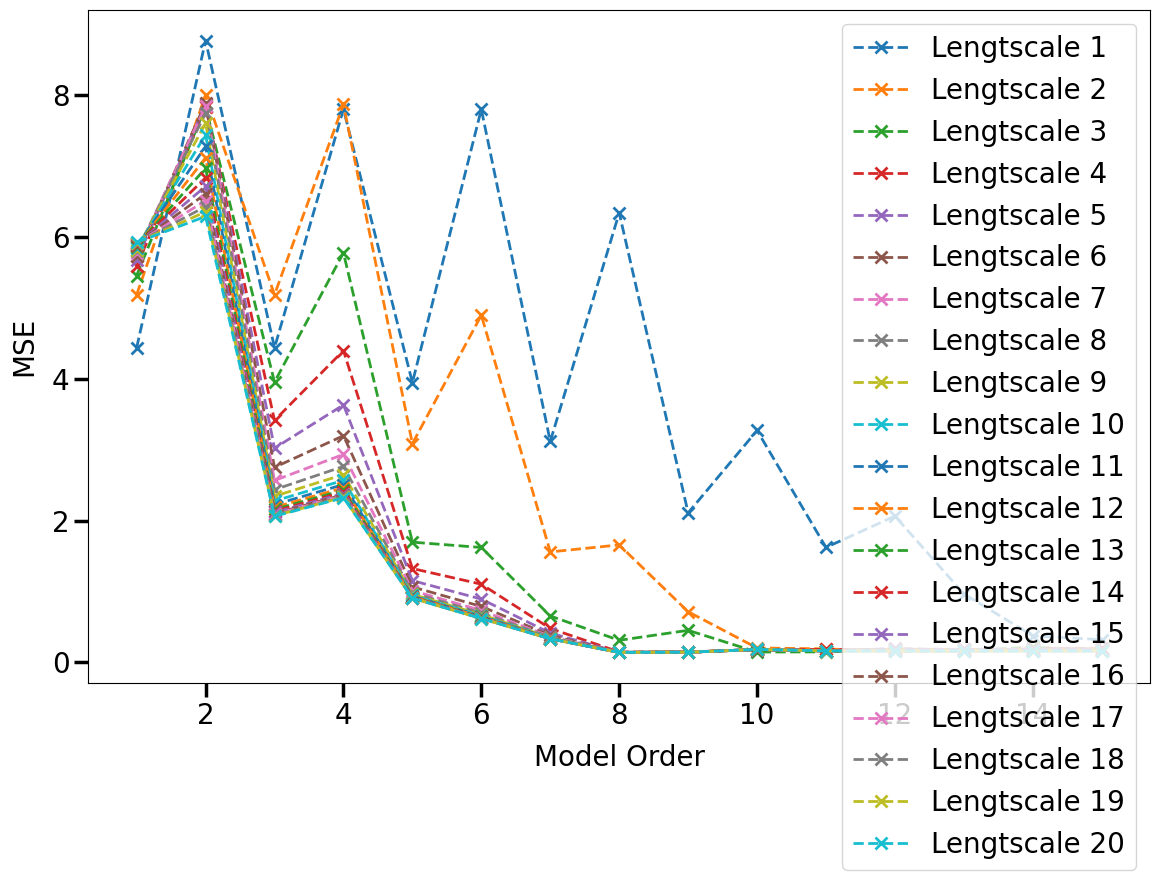

In [25]:
MSEmax_order = 15
max_lengthscale = 20
model_class = RBFModel

train_mse_list = []
test_mse_list = []
train_list = []
test_list = []
for order in range(1, max_order+1):
    for lengthscale in range(1, max_lengthscale+1):
        model = model_class(order, lengthscale)
        train_list.append(model.fit(x_train, y_train))
        test_mse = np.mean((model.predict(x_test) - y_test)**2)
        test_list.append(test_mse)
    train_mse_list.append(train_list)
    test_mse_list.append(test_list)
    train_list = []
    test_list = []

train_mse_list = np.array(train_mse_list)
test_mse_list = np.array(test_mse_list)

best_train_orders = np.argmin(train_mse_list, axis=0) + 1
# best_train_order = np.unravel_index(train_mse_list.argmin(), train_mse_list.shape)[0]
# print(f'Best train model has order {best_train_order[0] + 1} with train/test MSE is {train_mse_list.flatten()[best_train_order-1]} / {test_mse_list.flatten()[best_train_order-1]}.')

best_test_orders = np.argmin(test_mse_list, axis=0) + 1
# best_test_order = np.argmin(test_mse_list) + 1
# print(f'Best test model has order {best_test_order % max_lengthscale} with train/test MSE is {train_mse_list.flatten()[best_test_order-1]} / {test_mse_list.flatten()[best_test_order-1]}.')

plt.close('all')
plt.figure()
for lengthscale in range(1, max_lengthscale+1):
    plt.plot(list(range(1,max_order+1)), train_mse_list[:,lengthscale-1], 'x--', label=f'Lengtscale {lengthscale}')
plt.legend()
plt.xlabel('Model Order')
plt.ylabel('MSE')
plt.tight_layout()

plt.figure()
for lengthscale in range(1, max_lengthscale+1):
    plt.plot(list(range(1,max_order+1)), test_mse_list[:,lengthscale-1], 'x--', label=f'Lengtscale {lengthscale}')
plt.legend()
plt.xlabel('Model Order')
plt.ylabel('MSE')
plt.tight_layout()

if exportCSV:
    ord = np.reshape(list(range(1,max_order+1)), (-1, 1))
    dataFrame = np.concat((ord, train_mse_list), axis=1)
    np.savetxt("res/1_fitRBFTrain.csv", dataFrame, delimiter=",")
    dataFrame = np.concat((ord, test_mse_list), axis=1)
    np.savetxt("res/1_fitRBFTest.csv", dataFrame, delimiter=",")

compare best train and test models

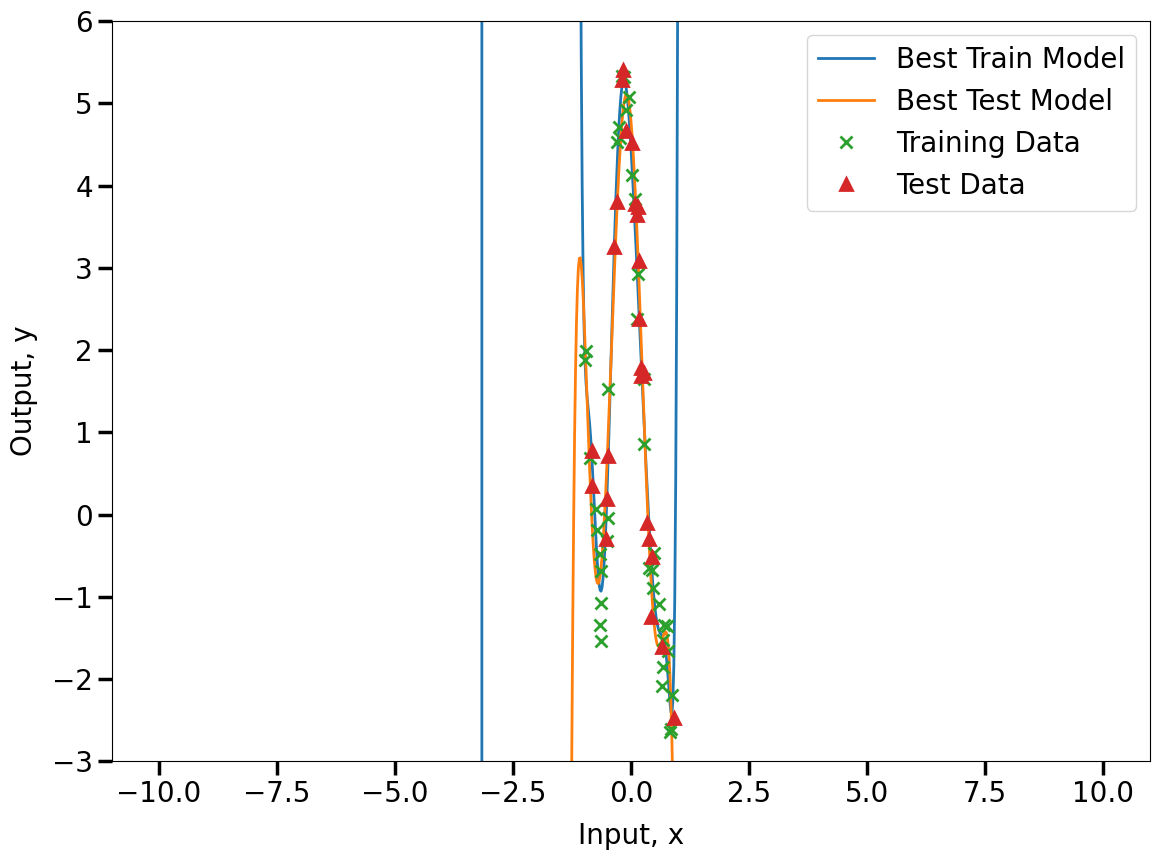

In [26]:
best_train_model = model_class(best_train_order)
_ = best_train_model.fit(x_train, y_train)

best_test_model = model_class(best_test_order)
_ = best_test_model.fit(x_train, y_train)


x_support = torch.linspace(-10., 10., 1000).numpy()
y_support_test = best_test_model.predict(x_support)
y_support_train = best_train_model.predict(x_support)

if exportCSV:
    dataFrame = np.stack((x_support, y_support_train ,y_support_test), axis=1)
    np.savetxt('res/1_resRBF.csv', dataFrame, delimiter=',', header='x,Train,Test')

plt.close('all')
plt.figure()
plt.plot(x_support, y_support_train, label='Best Train Model')
plt.plot(x_support, y_support_test, label='Best Test Model')
plt.plot(x_train, y_train, 'x', label='Training Data')
plt.plot(x_test, y_test, '^', label='Test Data')
plt.legend()
plt.xlabel('Input, x')
plt.ylabel('Output, y')
plt.ylim([-3, 6])
plt.tight_layout()

MLPModel

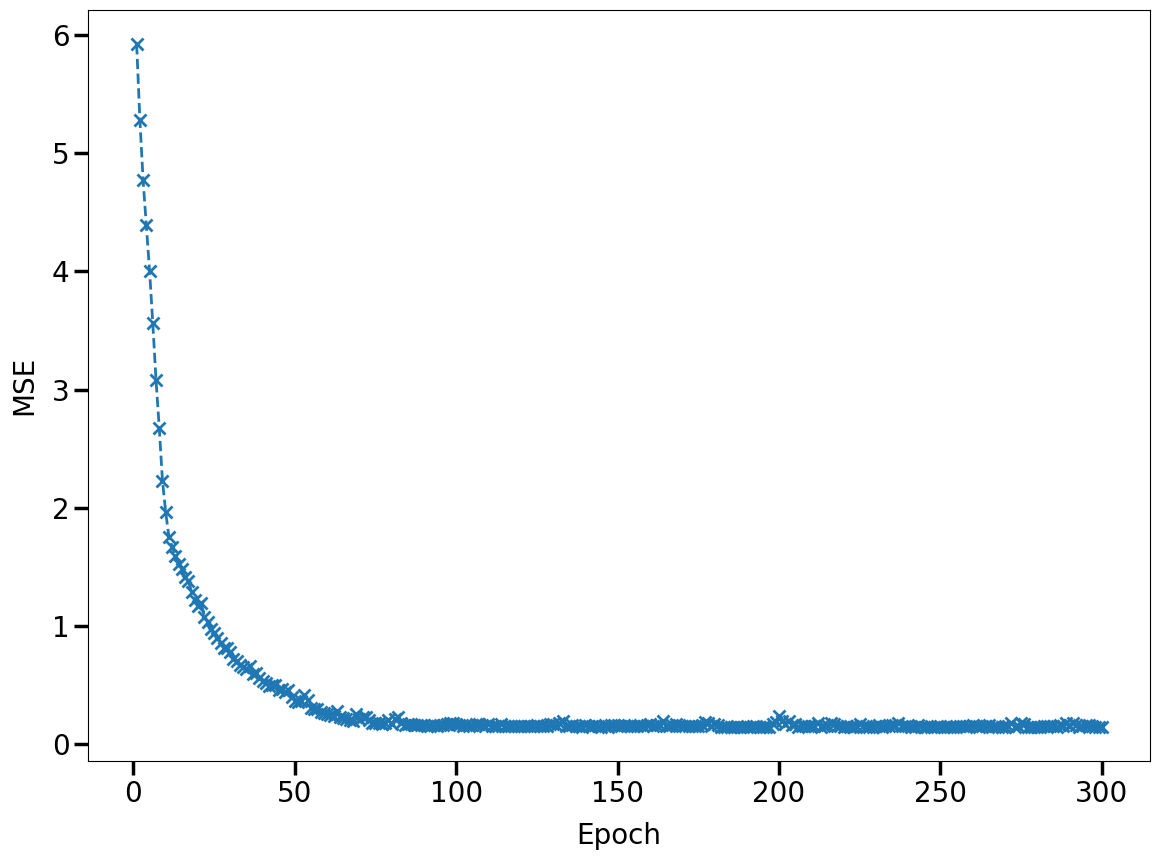

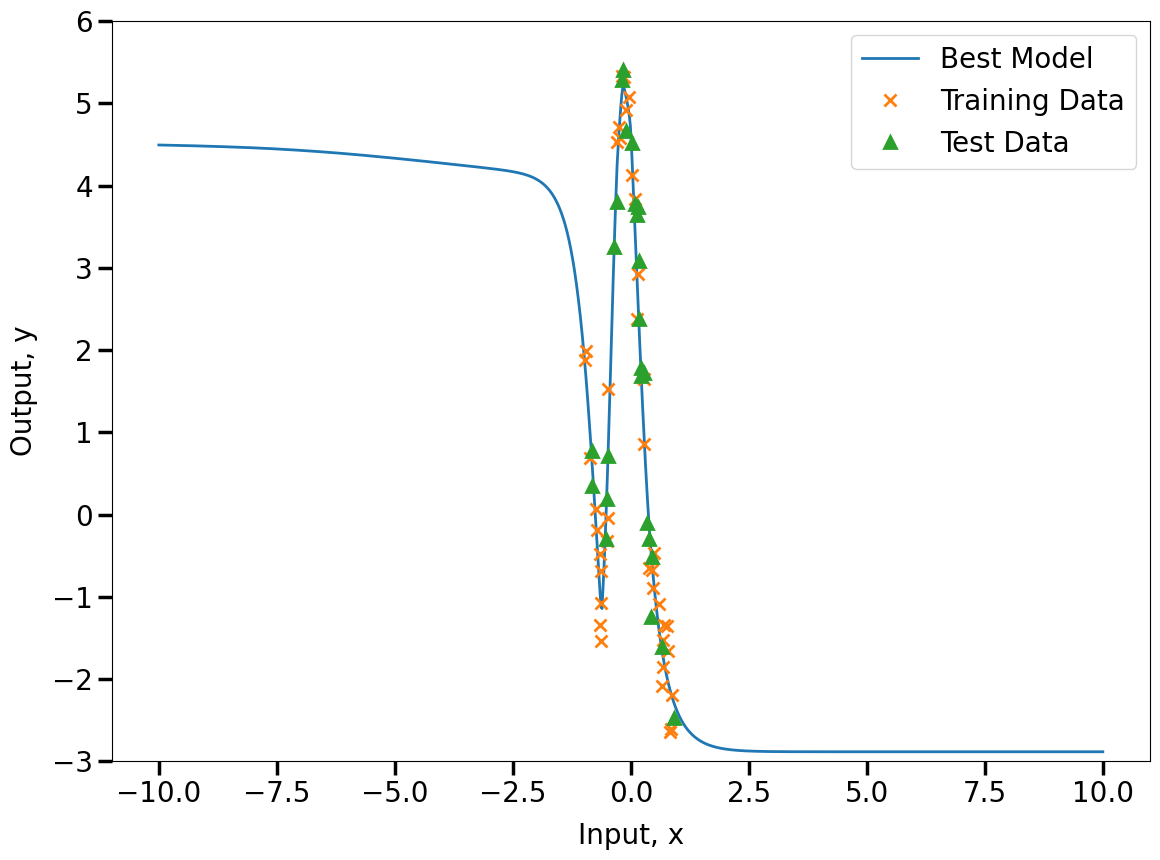

In [39]:
model = MLPModel()
train_mse = model.fit(x_train, y_train)
test_mse = np.mean((model.predict(x_test) - y_test)**2)

plt.close('all')
plt.figure()
plt.plot(list(range(1,len(train_mse)+1)), train_mse, 'x--')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.tight_layout()

if exportCSV:
    dataFrame = np.stack((np.array(list(range(1,len(train_mse)+1))), np.array(train_mse).flatten()), axis=1)
    np.savetxt("res/1_fitMLP.csv", dataFrame, delimiter=",", header="Model Order,Train MSE,Test MSE")

y_support = model.predict(x_support)
plt.figure()
plt.plot(x_support, y_support, label='Best Model')
plt.plot(x_train, y_train, 'x', label='Training Data')
plt.plot(x_test, y_test, '^', label='Test Data')
plt.legend()
plt.xlabel('Input, x')
plt.ylabel('Output, y')
plt.ylim([-3, 6])
plt.tight_layout()

if exportCSV:
    dataFrame = np.stack((x_support, y_support.ravel()), axis=1)
    np.savetxt('res/1_resMLP.csv', dataFrame, delimiter=',', header='x,y')
